In [39]:
# Importations
import pandas as pd
import warnings
import numpy as np
import gensim
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

warnings.filterwarnings('ignore')

### Data processing

In [40]:
df = pd.read_csv("entities.csv", sep='delimiter', header=None)
df = df[0].str.split(',', expand=True)

In [42]:
df = df.iloc[1:, :2].reset_index(drop=True).rename(columns={0:"text", 1:'label'})

In [43]:
df = df.loc[(df['text'].str.len() > 20) & (df['text'].str.len() < 80)]

In [44]:
df.loc[df['label'] == 'True', 'label'] = 1
df.loc[df['label'] == 'False', 'label'] = 0

df = df.loc[df['label'].isin([0,1])]
df['label'] = df['label'].astype(np.float32)

In [18]:
df

,text,label
0,Breton Cyrille menuisier 25 Garçon française,0.0
1,Ferazzi Auguste vitrier 30 Garçon Piémontaise,1.0
2,Machol Pierre vitrier 24 Garçon Piémontaise,1.0
3,Desbois Alexandre prop re 48 Homme marié franç...,1.0
4,Vignat Zélie prop re sa fe 30 française,0.0
...,...,...
25076,Chameton-Dideron Marie chef 1869 idem Pailharès,1.0
25077,Ode Marie ouv chaus res chef Cara 1863 idem St...,1.0
25078,Berni Nello manoeuvre chef Baretto 1886 italie...,1.0
25079,Berni-Laureti Annunziata épouse 1887 idem idem,0.0


In [45]:
texts = list(df['text'])
labels = list(df['label'])

In [46]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.1)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [47]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
train_labels_encoded = encoder.fit_transform(np.array(train_labels).reshape(-1,1))
test_labels_encoded = encoder.fit_transform(np.array(test_labels).reshape(-1,1))
val_labels_encoded = encoder.fit_transform(np.array(val_labels).reshape(-1,1))

### Stats descriptives

In [ ]:
df

,text,label
0,Breton Cyrille menuisier 25 Garçon française,0.0
1,Ferazzi Auguste vitrier 30 Garçon Piémontaise,1.0
2,Machol Pierre vitrier 24 Garçon Piémontaise,1.0
3,Desbois Alexandre prop re 48 Homme marié franç...,1.0
4,Vignat Zélie prop re sa fe 30 française,0.0
...,...,...
25076,Chameton-Dideron Marie chef 1869 idem Pailharès,1.0
25077,Ode Marie ouv chaus res chef Cara 1863 idem St...,1.0
25078,Berni Nello manoeuvre chef Baretto 1886 italie...,1.0
25079,Berni-Laureti Annunziata épouse 1887 idem idem,0.0


In [48]:
df['label'].value_counts()/len(df)

label
0.0    0.776431
1.0    0.223569
Name: count, dtype: float64

### Model CamemBert

In [50]:
from transformers import CamembertTokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenizer

CamembertTokenizer(name_or_path='camembert-base', vocab_size=32000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['<s>NOTUSED', '</s>NOTUSED', '<unk>NOTUSED']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<unk>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: Add

In [51]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [52]:
train_labels_encoded = train_labels_encoded.astype(np.float32)

In [53]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels_encoded)
val_dataset = IMDbDataset(val_encodings, val_labels_encoded)
test_dataset = IMDbDataset(test_encodings, test_labels_encoded)

In [54]:
from torch.utils.data import DataLoader
from transformers import CamembertForSequenceClassification, AdamW

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [67]:


model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

train_error = []
val_error = []

batch_size = 256

for epoch in range(15):
    print(epoch)

    epoch_average_loss_test = 0
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        epoch_average_loss_test += loss.item() * batch_size / len(val_loader)
    val_error.append(epoch_average_loss_test)

    epoch_average_loss_train = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        epoch_average_loss_train += loss.item() * batch_size / len(train_loader)
    train_error.append(epoch_average_loss_train)


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 1.0, 'Visualization of convergence')

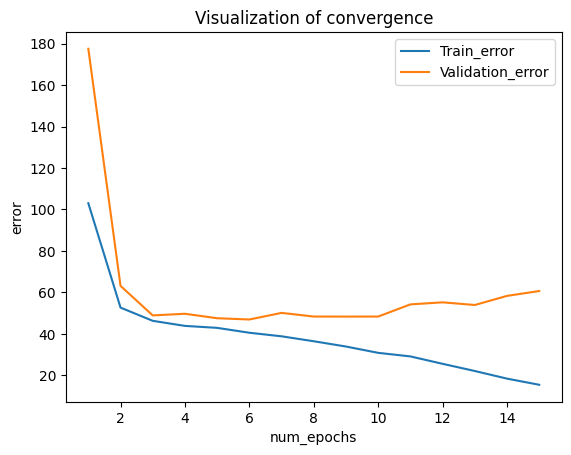

In [68]:
plt.plot(range(1, len(train_error) + 1), train_error,label='Train_error')
plt.plot(range(1, len(train_error) + 1), val_error,label='Validation_error')
plt.xlabel("num_epochs")
plt.ylabel("error")
plt.legend()
plt.title("Visualization of convergence")

In [69]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

correct = 0

for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels).logits
    outputs = torch.tensor(outputs > 0, dtype=torch.float32).to(device)
    correct += (outputs == batch['labels'].to(device)).sum() / 2

print(f'Accuracy: {round(correct.item()/len(test_loader)*100, 2)}%')

Accuracy: 92.18%


### model Word2Vec + XGBoost


In [19]:
df['text_clean'] = df['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
df

,text,label,text_clean
0,Breton Cyrille menuisier 25 Garçon française,0.0,"[breton, cyrille, menuisier, garçon, française]"
1,Ferazzi Auguste vitrier 30 Garçon Piémontaise,1.0,"[ferazzi, auguste, vitrier, garçon, piémontaise]"
2,Machol Pierre vitrier 24 Garçon Piémontaise,1.0,"[machol, pierre, vitrier, garçon, piémontaise]"
3,Desbois Alexandre prop re 48 Homme marié franç...,1.0,"[desbois, alexandre, prop, re, homme, marié, f..."
4,Vignat Zélie prop re sa fe 30 française,0.0,"[vignat, zélie, prop, re, sa, fe, française]"
...,...,...,...
25076,Chameton-Dideron Marie chef 1869 idem Pailharès,1.0,"[chameton, dideron, marie, chef, idem, pailharès]"
25077,Ode Marie ouv chaus res chef Cara 1863 idem St...,1.0,"[ode, marie, ouv, chaus, res, chef, cara, idem..."
25078,Berni Nello manoeuvre chef Baretto 1886 italie...,1.0,"[berni, nello, manoeuvre, chef, baretto, itali..."
25079,Berni-Laureti Annunziata épouse 1887 idem idem,0.0,"[berni, laureti, annunziata, épouse, idem, idem]"


In [22]:
X_train, X_test, y_train, y_test = train_test_split (df['text_clean'], df['label'] , test_size=0.2)

In [28]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [30]:
words = set(w2v_model.wv.index_to_key)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train], dtype="object")
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test], dtype="object")

In [32]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [33]:
X_train_vect_avg

[array([ 0.02181056,  0.5850267 ,  0.07874171,  0.17153423,  0.13856229,
        -0.5259983 ,  0.48746702,  0.74620795, -0.416471  , -0.66185606,
         0.34631443, -0.382519  ,  0.37921727,  0.1383556 ,  0.41336823,
        -0.30685303,  0.50914544, -0.51032716, -0.58615065, -0.6221604 ,
         0.03798282, -0.2245393 ,  0.55296296, -0.39894828, -0.28308892,
         0.01622156, -0.18159707,  0.06633165, -0.29462716,  0.08523598,
         0.2749186 , -0.26625776, -0.1084886 , -0.6100723 , -0.04985724,
         0.3578361 ,  0.16113818, -0.33347204, -0.39019418, -0.42857304,
        -0.08335414, -0.16221042, -0.11192431, -0.04580844,  0.32046098,
        -0.257577  , -0.01525712, -0.06703103,  0.02136777,  0.41676798,
         0.17193049, -0.5806791 , -0.21656637, -0.15017535, -0.47391662,
        -0.02567832,  0.3708655 , -0.03317445, -0.37265697, -0.20326059,
         0.368219  , -0.05686247,  0.40149316, -0.04298493, -0.320223  ,
         0.766393  ,  0.01249394,  0.50322264, -0.7

In [34]:
import xgboost as xgb

In [36]:
# Instantiate and fit a XGBoost model on top of the vectors
xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=2)
xgb_model = xgb.fit(X_train_vect_avg, y_train.values.ravel())

In [37]:
# Predictions on the test data
y_pred = xgb_model.predict(X_test_vect_avg)

In [38]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.776 / Recall: 0.85 / Accuracy: 0.911
